In [1]:
!uv pip install -q --system numba-cuda==0.4.0

In [1]:
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CPU Image processing

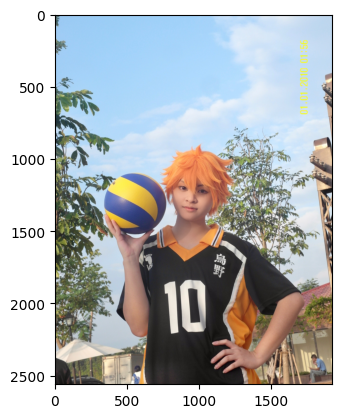

In [2]:
img_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8500.JPG"
img = plt.imread(img_path)
plt.imshow(img)

In [5]:
@cuda.jit
def grayscale(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

(4915200, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
CUDA runtime: 1.1180646419525146
(4915200, 1)


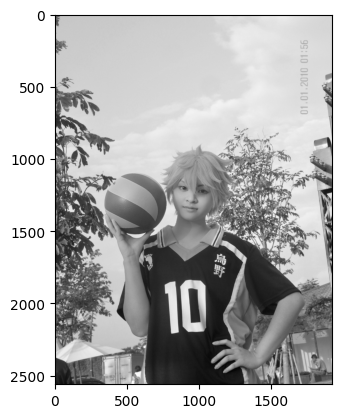

In [7]:
compressed_img = img.reshape(img.shape[0]* img.shape[1], 3)
compressed_img_cuda = cuda.to_device(compressed_img)
print(compressed_img_cuda.shape)
print(type(compressed_img_cuda))
block_size = 64
pixel_count = img.shape[0] * img.shape[1]
grid_size = int(pixel_count/block_size)
gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
start = time.time()
grayscale[grid_size, block_size](compressed_img_cuda, gray_img_cuda)
end = time.time()

gray_img_host = gray_img_cuda.copy_to_host()
print(f"CUDA runtime: {end-start}")
print(gray_img_host.shape)
gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)
plt.imshow(gray_img, cmap="gray")

GrayScale (GPU, From Scratch)

In [3]:
@cuda.jit
def grayscale2d(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  if tidx < src.shape[0] and tidy < src.shape[1]:
    g = ((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
    dst[tidx, tidy, 0] = g
    dst[tidx, tidy, 1] = g
    dst[tidx, tidy, 2] = g


Grayscale GPU 2D

(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
0.4068429470062256


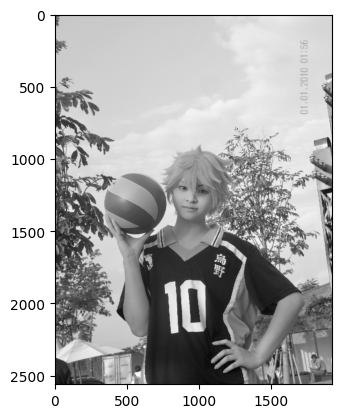

In [4]:
import math
img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
block_size = (32, 8)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 1))
start = time.time()
grayscale2d[grid_size, block_size](img_cuda, gray_img_cuda)
end = time.time()
print(end-start)
gray_img = gray_img_cuda.copy_to_host()
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(gray_img, cmap="gray")

In [8]:
import os
img_paths = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22"
block_size = []
for img in os.listdir(img_paths):
  img_path = os.path.join(img_paths, img)
  img = plt.imread(img_path)
  img_cuda = cuda.to_device(img)
  print(img_cuda.shape)
  print(type(img_cuda))
  block_size = (32, 8)
  grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

  gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 1))
  start = time.time()
  grayscale2d[grid_size, block_size](img_cuda, gray_img_cuda)
  end = time.time()
  print(end-start)
  gray_img = gray_img_cuda.copy_to_host()
  # gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)




(1922, 2537, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
0.00029921531677246094


UnidentifiedImageError: cannot identify image file '/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8409.HEIC'